# Current Codes

In [ ]:
import pandas as pd
import numpy as np
import random
import uuid
from datetime import timedelta, datetime
from scipy.special import expit  # Sigmoid function

# Reproducibility
np.random.seed(42)
random.seed(42)

# Constants
locations = {
    "Mumbai": (19.0760, 72.8777, "Urban"),
    "Delhi": (28.6139, 77.2090, "Urban"),
    "Chennai": (13.0827, 80.2707, "Urban"),
    "Kolkata": (22.5726, 88.3639, "Urban"),
    "San Francisco": (37.7749, -122.4194, "Urban"),
    "New York": (40.7128, -74.0060, "Urban"),
    "Tokyo": (35.6895, 139.6917, "Urban"),
    "Berlin": (52.5200, 13.4050, "Urban"),
}
network_types = ["4G", "5G NSA", "5G SA"]
carriers = ["Jio", "Airtel", "Vi", "AT&T", "T-Mobile", "BSNL"]
device_models = ["iPhone 14", "Pixel 7", "Galaxy S23", "GT 7", "Nord 4"]
bands = ["n78", "n28", "n258", "n260", "n41"]
weather_types = ["Clear", "Rainy", "Foggy"]
obstruction_levels = ["Low", "Medium", "High"]
movement_speeds = ["Static", "Walking", "Driving"]
app_types = ["Streaming", "Browsing", "Gaming", "Call"]
tower_load_levels = ["Light", "Moderate", "Heavy"]
band_penalty = {
    "n78": 0,     # mid-band, decent range and speed
    "n28": 2,     # low-band, better penetration but slightly higher PL
    "n258": 5,    # mmWave, short range
    "n260": 6,    # mmWave, worse than n258
    "n41": 3      # mid-high band
}

# Signal model parameters
PL0 = 30
d0 = 0.01
path_loss_exponent = 4.0

def log_distance_path_loss(distance_km):
    return PL0 + 10 * path_loss_exponent * np.log10(max(distance_km, d0) / d0)

def generate_signal_strength(network_type, distance_km, obstruction, weather, movement_speed, band):
    tx_power = {"5G SA": 43, "5G NSA": 43, "4G": 43}
    pl = log_distance_path_loss(distance_km)
    obstruction_penalty = {"Low": 0, "Medium": 5, "High": 12}[obstruction]
    weather_penalty = {"Clear": 0, "Rainy": 3, "Foggy": 6}[weather]
    mobility_penalty = {"Static": 0, "Walking": 1, "Driving": 4}[movement_speed]
    fading = np.random.normal(0, 3)
    band_loss = band_penalty.get(band, 0)  # Default to 0 if unknown
    return tx_power[network_type] - pl - obstruction_penalty - weather_penalty - mobility_penalty - band_loss + fading

def generate_latency(signal_strength, congestion, vonr_enabled, network_type):
    base_latency = np.interp(signal_strength, [-120, -60], [250, 10])
    congestion_factor = {"Low": 1.0, "Medium": 1.6, "High": 2.5}  # Stronger effect
    network_latency_factor = {"5G SA": 0.7, "5G NSA": 1.0, "4G": 1.3}[network_type]

    latency = base_latency * congestion_factor[congestion] * network_latency_factor
    if vonr_enabled:
        latency *= 0.85

    return np.clip(latency + np.random.normal(0, 10), 5, 500)  # Slightly more jitter

def generate_jitter(latency, movement_speed):
    base_jitter = latency / 20
    mobility_factor = {"Static": 0.7, "Walking": 1.0, "Driving": 1.4}[movement_speed]
    return np.clip(np.random.normal(base_jitter * mobility_factor, 1.5), 0.1, 50)

from scipy.special import expit  # Already in your imports

def generate_speed(signal_strength, congestion, movement_speed, network_type, latency):
    max_speeds = {"4G": 150, "5G NSA": 600, "5G SA": 1200}
    base_speed = np.interp(signal_strength, [-120, -60], [0, max_speeds[network_type]])

    congestion_multiplier = {"Low": 1.0, "Medium": 0.6, "High": 0.3}
    movement_penalty = {"Static": 1.0, "Walking": 0.95, "Driving": 0.85}[movement_speed]

    # 📉 Latency penalty using a sigmoid for smooth decay
    latency_penalty = expit(-(latency - 140) / 20) * 0.7 + 0.3
    #     sigmoid: ~1 when latency << 140, ~0.3 when latency >> 140

    speed = base_speed * congestion_multiplier[congestion] * movement_penalty * latency_penalty

    noise = np.random.normal(0, max_speeds[network_type] * 0.1)
    return max(0, speed + noise)

def generate_video_quality(download_speed, latency, jitter, congestion, app_type):
    if app_type != "Streaming":
        return 0

    # Higher influence on scoring
    speed_score = np.clip(download_speed / 250, 0, 1.2)  # Looser upper bound
    latency_score = np.clip(1 - latency / 120, 0, 1.0)
    jitter_score = np.clip(1 - jitter / 15, 0, 1.0)
    congestion_bonus = {"Low": 1.0, "Medium": 0.5, "High": 0.0}[congestion]

    score = (
        0.55 * speed_score +
        0.25 * latency_score +
        0.1 * jitter_score +
        0.1 * congestion_bonus
    )

    # Add mild variance so not all values are 4 or 5
    score += np.random.normal(0, 0.05)

    return round(np.clip(score * 5, 1, 5), 2)  # Keep decimals for correlation

def generate_dropped_connection(signal_strength, latency, jitter, congestion, network_type, battery, duration, carrier, anomaly, tower_load):
    w_signal = 0.07 * np.clip(-signal_strength - 60, 0, 60)
    w_latency = 0.02 * max(latency - 100, 0)
    w_jitter = 0.04 * max(jitter - 10, 0)
    w_congestion = {"Low": 0, "Medium": 1.0, "High": 2.0}[congestion]
    w_network = {"4G": 1.0, "5G NSA": 0.5, "5G SA": 0}[network_type]
    w_battery = 1.5 if battery < 15 else 0
    w_duration = 0.02 * max(duration - 50, 0)
    w_carrier = 1.0 if carrier in ["Vi", "BSNL"] else 0
    w_anomaly = 3.0 if anomaly else 0
    w_tower_load = {"Light": 0, "Moderate": 0.8, "Heavy": 1.6}[tower_load]
    linear_combination = -3 + w_signal + w_latency + w_jitter + w_congestion + w_network + w_battery + w_duration + w_carrier + w_anomaly + w_tower_load
    return random.random() < expit(linear_combination)

def hour_based_congestion(hour):
    if 8 <= hour <= 11 or 18 <= hour <= 21:
        return random.choices(["Low", "Medium", "High"], weights=[0.2, 0.5, 0.3])[0]
    elif 0 <= hour <= 6:
        return random.choices(["Low", "Medium", "High"], weights=[0.6, 0.3, 0.1])[0]
    else:
        return random.choices(["Low", "Medium", "High"], weights=[0.4, 0.4, 0.2])[0]

In [ ]:
# Generate dataset
rows = 50000
start_time = datetime.now()
data = []

for _ in range(rows):
    user_id = str(uuid.uuid4())[:8]
    session_id = str(uuid.uuid4())[:8]
    timestamp = start_time + timedelta(seconds=random.randint(0, 3600 * 24))
    hour = timestamp.hour
    day_of_week = timestamp.strftime("%A")
    is_weekend = day_of_week in ["Saturday", "Sunday"]

    location_name = random.choice(list(locations.keys()))
    lat, lon, area_type = locations[location_name]
    lat += np.random.normal(0, 0.01)
    lon += np.random.normal(0, 0.01)

    network_type = random.choice(network_types)
    carrier = random.choice(carriers)
    device = random.choice(device_models)
    band = random.choice(bands)
    tower_load = random.choices(tower_load_levels, weights=[0.4, 0.4, 0.2])[0]

    congestion = hour_based_congestion(hour)
    weather = random.choices(weather_types, weights=[0.6, 0.3, 0.1])[0]
    obstruction = random.choices(obstruction_levels, weights=[0.5, 0.3, 0.2])[0]
    movement_speed = random.choices(movement_speeds, weights=[0.4, 0.4, 0.2])[0]
    app_type = random.choice(app_types)
    tower_id = f"TWR-{random.randint(1000, 9999)}"
    distance_to_tower = round(np.random.uniform(0.05, 5.0), 3)

    vonr_enabled = (network_type == "5G SA") and (random.random() > 0.2)
    battery = random.randint(10, 100)
    temperature = round(np.interp(battery, [10, 100], [42, 25]) + np.random.normal(0, 1.5), 1)
    duration = random.randint(1, 60)
    handovers = {
        "Static": np.random.poisson(0.5),
        "Walking": np.random.poisson(2),
        "Driving": np.random.poisson(4)
    }[movement_speed]

    anomaly_prob = 0.05
    anomaly = random.random() < anomaly_prob

    signal_strength = round(generate_signal_strength(network_type, distance_to_tower, obstruction, weather, movement_speed, band), 1)
    latency = round(generate_latency(signal_strength, congestion, vonr_enabled, network_type), 1)
    jitter = round(generate_jitter(latency, movement_speed), 2)
    download_speed = round(generate_speed(signal_strength, congestion, movement_speed, network_type, latency), 2)
    upload_speed = round(download_speed * np.random.uniform(0.1, 0.4), 2)
    data_usage = round(download_speed * duration * 0.02, 2)
    ping = round(latency + np.random.normal(0, 5), 1)
    video_quality = generate_video_quality(download_speed, latency, jitter, congestion, app_type)
    dropped = generate_dropped_connection(signal_strength, latency, jitter, congestion, network_type, battery, duration, carrier, anomaly, tower_load)

    data.append([
        timestamp, hour, day_of_week, is_weekend,
        user_id, session_id,
        location_name, lat, lon, area_type,
        signal_strength, download_speed, upload_speed, latency, jitter, ping,
        network_type, device, carrier, band,
        battery, temperature, duration, handovers, data_usage,
        congestion, movement_speed, app_type, weather, obstruction,
        tower_id, distance_to_tower, tower_load,
        video_quality, vonr_enabled, anomaly, dropped
    ])

columns = [
    "Timestamp", "Hour", "Day_of_Week", "Is_Weekend",
    "User_ID", "Session_ID",
    "Location", "Latitude", "Longitude", "Area_Type",
    "Signal_Strength_dBm", "Download_Speed_Mbps", "Upload_Speed_Mbps",
    "Latency_ms", "Jitter_ms", "Ping_ms",
    "Network_Type", "Device_Model", "Carrier", "Band",
    "Battery_Level_percent", "Temperature_C", "Connected_Duration_min", "Handover_Count", "Data_Usage_MB",
    "Congestion_Level", "Movement_Speed", "App_Type", "Weather", "Obstruction_Level",
    "Tower_ID", "Distance_to_Tower_km", "Tower_Load",
    "Video_Quality", "VoNR_Enabled", "Anomalous", "Dropped_Connection"
]

df = pd.DataFrame(data, columns=columns)
df.to_csv("5G_realistic_synthetic_dataset_revised.csv", index=False)
print("Dataset saved as '5G_realistic_synthetic_dataset_revised.csv'")

Dataset saved as '5G_realistic_synthetic_dataset_revised.csv'


In [ ]:
# Only streaming entries
streaming_only = df[df["App_Type"] == "Streaming"]

# Check correlations
corrs = streaming_only[[
    "Video_Quality", "Download_Speed_Mbps", "Latency_ms",
    "Jitter_ms", "Signal_Strength_dBm", "Dropped_Connection"
]].corr()

print(corrs["Video_Quality"].sort_values(ascending=False))

Video_Quality          1.000000
Download_Speed_Mbps    0.846803
Signal_Strength_dBm    0.461683
Dropped_Connection    -0.517914
Jitter_ms             -0.682777
Latency_ms            -0.760530
Name: Video_Quality, dtype: float64


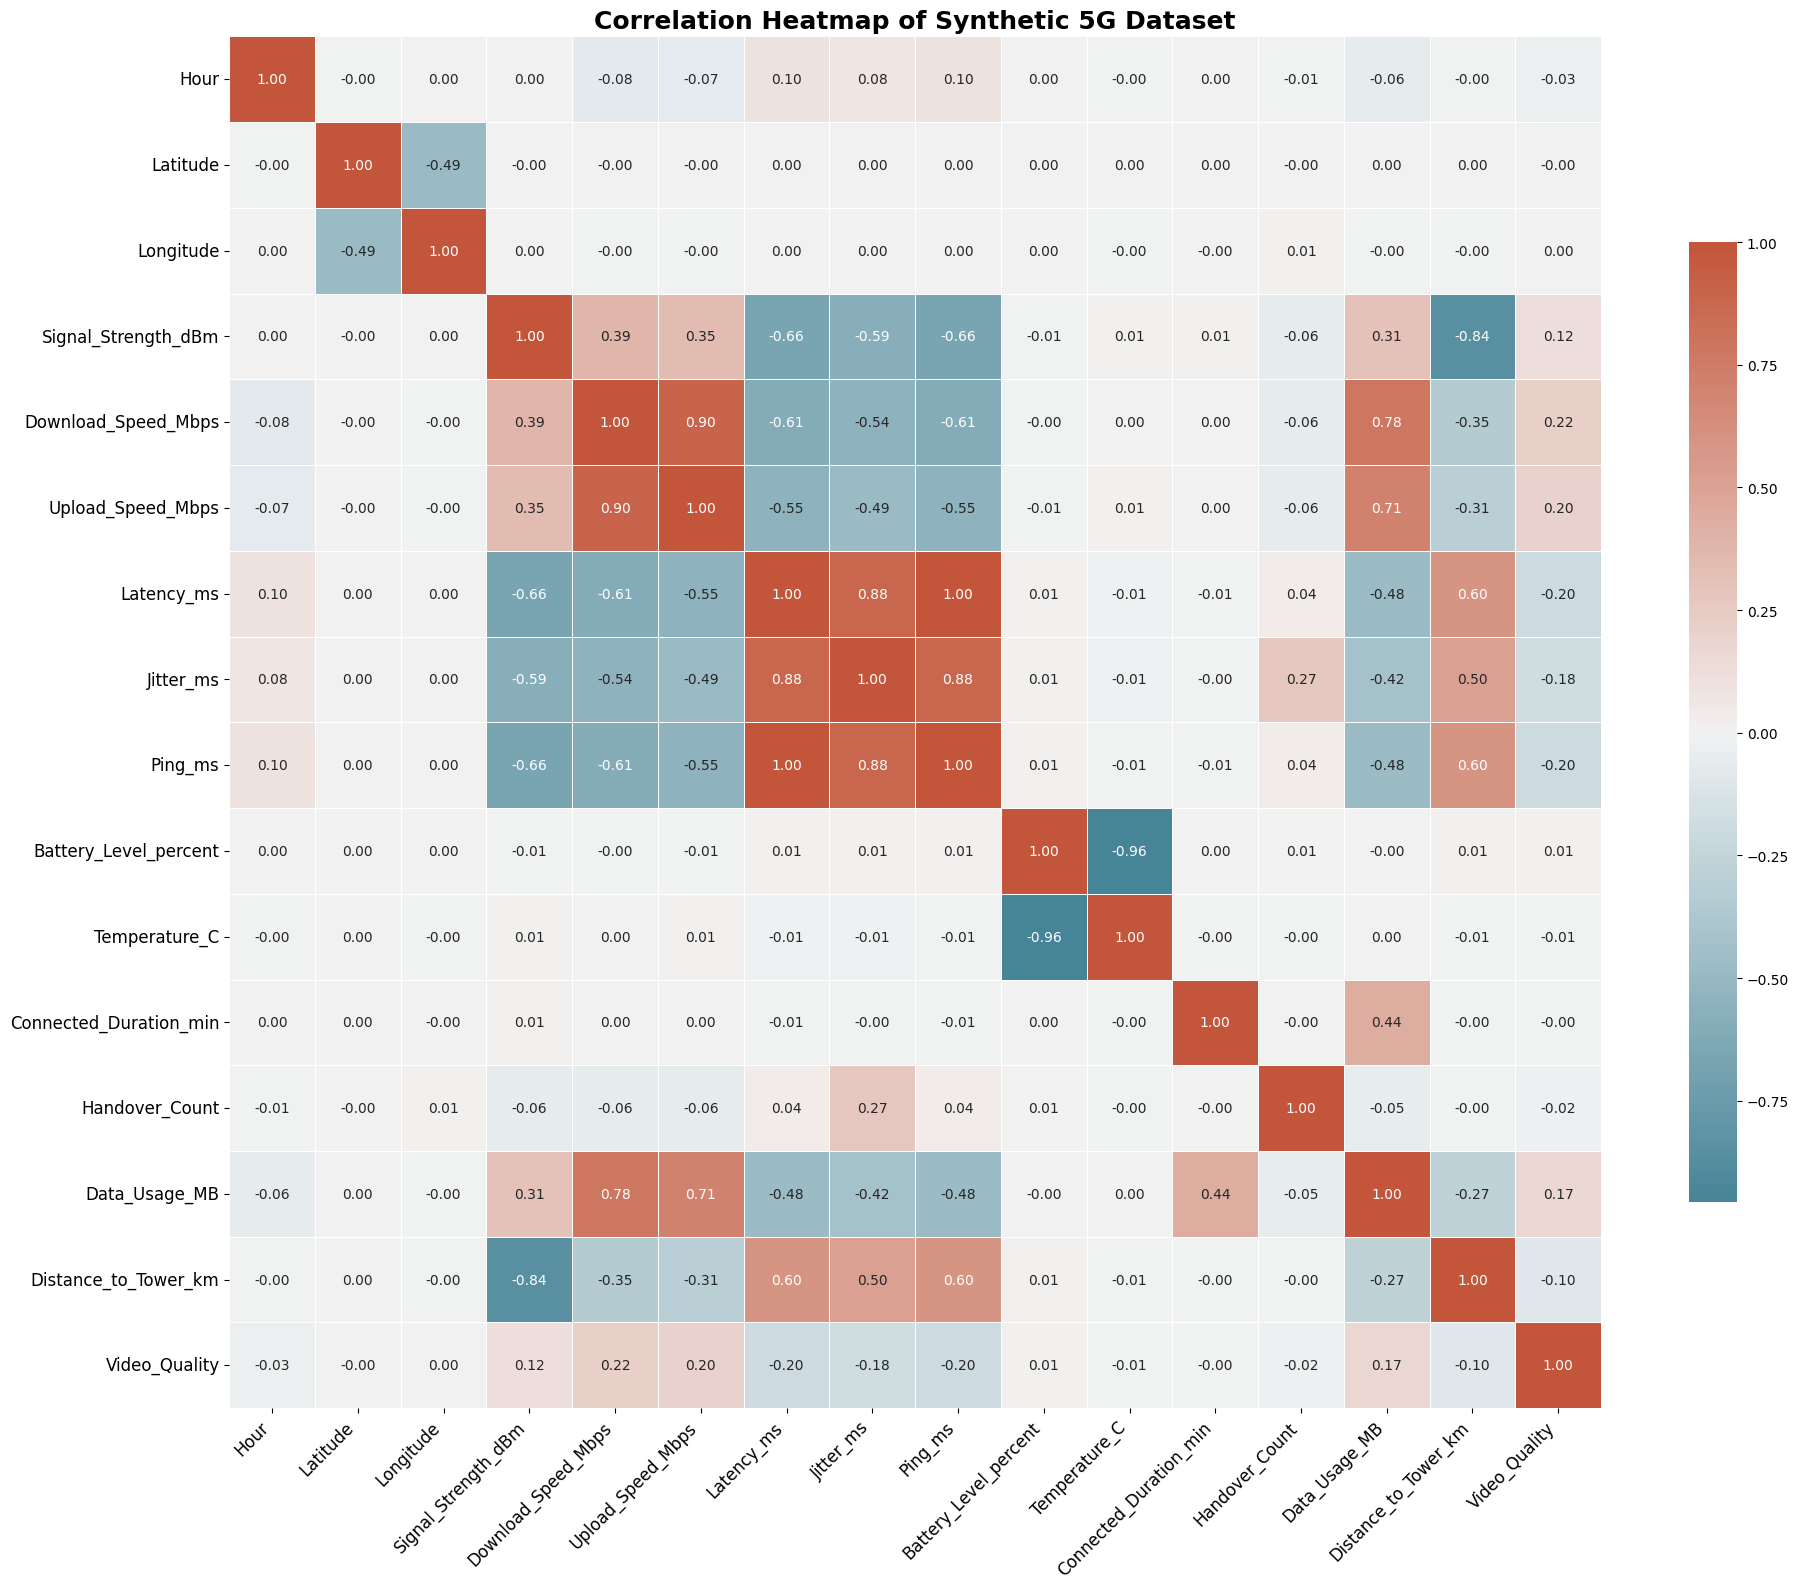

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Select only numeric columns for correlation
numeric_cols = df.select_dtypes(include=[float, int]).columns

# Compute correlation matrix
corr = df[numeric_cols].corr()

# Set up the matplotlib figure size (wide and tall for big heatmap)
plt.figure(figsize=(20, 16))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap with annotations, center at 0, and large font sizes for readability
sns.heatmap(
    corr,
    cmap=cmap,
    center=0,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 10},
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.7},
)

plt.title("Correlation Heatmap of Synthetic 5G Dataset", fontsize=18, weight='bold')
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()


🔍 Top correlations with Video_Quality:
Video_Quality           1.000000
Download_Speed_Mbps     0.846803
Upload_Speed_Mbps       0.758124
Data_Usage_MB           0.658611
Signal_Strength_dBm     0.461683
Hour                   -0.085501
Distance_to_Tower_km   -0.394662
Jitter_ms              -0.682777
Ping_ms                -0.759865
Latency_ms             -0.760530
Name: Video_Quality, dtype: float64


/tmp/ipython-input-7-3365614037.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


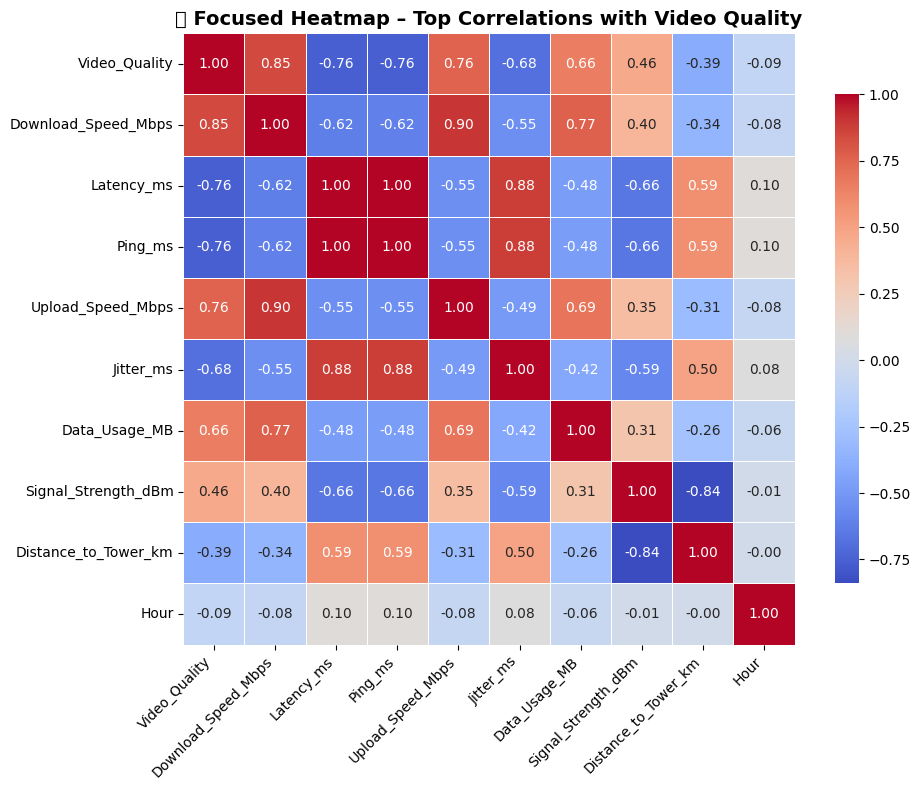

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 📌 1. Filter to Streaming app type only
streaming_df = df[df["App_Type"] == "Streaming"]

# 📌 2. Select only numeric columns
numeric_cols = streaming_df.select_dtypes(include=[float, int]).columns

# 📌 3. Compute correlation matrix
corr = streaming_df[numeric_cols].corr()

# 📌 4. Show top 10 features most correlated with Video_Quality
top_corr = corr["Video_Quality"].abs().sort_values(ascending=False).head(10)
print("🔍 Top correlations with Video_Quality:")
print(corr["Video_Quality"].loc[top_corr.index].sort_values(ascending=False))

# 📌 5. Plot heatmap of only the top 10 correlated features
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr.loc[top_corr.index, top_corr.index],
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("🎯 Focused Heatmap – Top Correlations with Video Quality", fontsize=14, weight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 📌 6. Optional: Save heatmap as image
# plt.savefig("video_quality_top_correlations_heatmap.png", dpi=300)


# Previous Codes